In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pickle
import os
import pandas as pd
import tensorflow as tf
import keras
from keras import layers

In [ ]:
# change the file path before running it
def load_ae_data(train_file='/Users/admin/Desktop/Code/data/ae.train', test_file='/Users/admin/Desktop/Code/data/ae.test'):
    """
    Load and parse the ape call data from ASCII files.
    
    Returns:
    - train_inputs: list of numpy arrays (270 time series, each N x 12)
    - test_inputs: list of numpy arrays (370 time series, each N x 12) 
    - train_outputs: list of numpy arrays (270 time series, each N x 9)
    - test_outputs: list of numpy arrays (370 time series, each N x 9)
    - N is the length of the time series, varying per sample
    """
    
    # Load the data
    ae_train = np.loadtxt(train_file)
    ae_test = np.loadtxt(test_file)
    
    # Parse training data
    train_inputs = []
    read_index = 0
    
    for c in range(270):
        start_index = read_index
        # Find the length of current time series (until we hit a row of 1.0s)
        while read_index < len(ae_train) and ae_train[read_index, 0] != 1.0:
            read_index += 1
        
        # Extract the time series
        time_series = ae_train[start_index:read_index, :]
        train_inputs.append(time_series)
        
        # Skip the separator row of 1.0s
        read_index += 1
    
    # Parse test data
    test_inputs = []
    read_index = 0
    
    for c in range(370):
        start_index = read_index
        # Find the length of current time series
        while read_index < len(ae_test) and ae_test[read_index, 0] != 1.0:
            read_index += 1
        
        # Extract the time series
        time_series = ae_test[start_index:read_index, :]
        test_inputs.append(time_series)
        
        # Skip the separator row of 1.0s
        read_index += 1
    
    # Generate teacher signals (outputs)
    train_outputs = []
    for c in range(270):
        length = len(train_inputs[c])
        teacher = np.zeros((length, 9))
        speaker_index = c // 30  # 30 samples per speaker, 9 speakers total
        teacher[:, speaker_index] = 1
        train_outputs.append(teacher)
    
    test_outputs = []
    speaker_index = 0
    block_counter = 0
    block_lengths = [31, 35, 88, 44, 29, 24, 40, 50, 29]  # samples per speaker in test set
    
    for c in range(370):
        if block_counter == block_lengths[speaker_index]:
            speaker_index += 1
            block_counter = 0
        
        length = len(test_inputs[c])
        teacher = np.zeros((length, 9))
        teacher[:, speaker_index] = 1
        test_outputs.append(teacher)
        
        block_counter += 1
    
    return train_inputs, test_inputs, train_outputs, test_outputs

In [ ]:
# Create data directory if it doesn't exist
os.makedirs('/Users/admin/Desktop/Code/data', exist_ok=True)

# Load the data
train_inputs, test_inputs, train_outputs, test_outputs = load_ae_data()

# Save the data as separate pickle files
with open('/Users/admin/Desktop/Code/data/train_inputs.pkl', 'wb') as f:
    pickle.dump(train_inputs, f)
with open('/Users/admin/Desktop/Code/data/test_inputs.pkl', 'wb') as f:
    pickle.dump(test_inputs, f)
with open('/Users/admin/Desktop/Code/data/train_outputs.pkl', 'wb') as f:
    pickle.dump(train_outputs, f)
with open('/Users/admin/Desktop/Code/data/test_outputs.pkl', 'wb') as f:
    pickle.dump(test_outputs, f)

In [2]:
def load_saved_data(data_folder='/Users/admin/Desktop/Code/data'):
    """
    Load the preprocessed ape call data from pickle files.
    
    Args:
        data_folder (str): Path to the folder containing pickle files
        
    Returns:
        tuple: (train_inputs, test_inputs, train_outputs, test_outputs)
    """
    try:
        with open(f'{data_folder}/train_inputs.pkl', 'rb') as f:
            train_inputs = pickle.load(f)
        with open(f'{data_folder}/test_inputs.pkl', 'rb') as f:
            test_inputs = pickle.load(f)
        with open(f'{data_folder}/train_outputs.pkl', 'rb') as f:
            train_outputs = pickle.load(f)
        with open(f'{data_folder}/test_outputs.pkl', 'rb') as f:
            test_outputs = pickle.load(f)
        
        print(f"Data loaded successfully from {data_folder}/")
        print(f"Train samples: {len(train_inputs)}, Test samples: {len(test_inputs)}")
        print(f"Input dimensions: {train_inputs[0].shape[1]}, Output dimensions: {train_outputs[0].shape[1]}")
        
        return train_inputs, test_inputs, train_outputs, test_outputs
        
    except FileNotFoundError as e:
        print(f"Error: {e}")
        return None, None, None, None
    except Exception as e:
        print(f"Error loading data: {e}")
        return None, None, None, None

In [3]:
train_inputs, test_inputs, train_outputs, test_outputs = load_saved_data('data')

Data loaded successfully from data/
Train samples: 270, Test samples: 370
Input dimensions: 12, Output dimensions: 9


In [4]:
#get the maximum length for the trainning data set
def max_Len(input_data):
    length = [i.shape[0] for i in input_data]
    return int(max(length))

In [5]:
#padding
def padding_to_maxl(input_data,max_l):
    padding_data = []
    for i in input_data:
        Time_step, LPC = i.shape
        if Time_step >= max_l:
            padding = i[:max_l]
        else:
            padding = np.pad(i, ((0,max_l-Time_step),(0,0)), mode="constant", constant_values=0.0)
        padding_data.append(padding)
    return np.stack(padding_data,axis = 0)

In [6]:
Length = max_Len(train_inputs)
padding_train_data = padding_to_maxl(train_inputs, Length)
padding_test_data = padding_to_maxl(test_inputs, Length)

print(f"padding train input: {padding_train_data.shape}")
print(f"padding test input: {padding_test_data.shape}")

padding train input: (270, 26, 12)
padding test input: (370, 26, 12)


# Rocket data fitting and exploring the features

In [7]:
from modified_rocket import RocketConfigurable
from sklearn.linear_model import RidgeClassifierCV
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns

In [8]:
# This is necessary because the algorithm expects the input shape to be of (N_samples, N_channels, N_timeteps)
train_transpose = padding_train_data.transpose(0, 2, 1)
test_transpose = padding_test_data.transpose(0, 2, 1)

# Getting the speaker label per sample
y_train = np.array([np.argmax(arr) for arr in train_outputs])
y_test = np.array([np.argmax(arr) for arr in test_outputs])

In [9]:
# We want to normalise per channel, so we calculate mean and std per channel across all samples and timesteps
channel_means = train_transpose.mean(axis=(0, 2), keepdims=True)
channel_stds  = train_transpose.std(axis=(0, 2), keepdims=True)

train_norm = (train_transpose - channel_means) / channel_stds

# Applying same normalization to test data
test_norm = (test_transpose - channel_means) / channel_stds


# Trying a standard configuration, i.e. 'ppv + max'

In [ ]:
ROCKET = RocketConfigurable(num_kernels=500, features='ppv+max', normalise=False, random_state=12)
X_train = ROCKET.fit_transform(train_transpose)

Some correlation investigation. Because there are too many features, we are focusing on 200 only. 

In [ ]:
subset = (pd.DataFrame(X_train)).sample(n=200, axis=1)
sns.heatmap(np.corrcoef(subset, rowvar=False), cmap="coolwarm", center=0)

As we can see, there are features that are highly correlated. But ridge classifier should be able to ahndle them. We coudl also do PCA.

In [ ]:
df = pd.DataFrame(X_train)
df["class"] = y_train

In [ ]:
ppv_features = df.iloc[:, np.arange(0, 1000, 2)]

ppv_mean = ppv_features.mean(axis=1)
plt.figure(figsize=(8,5))
plt.boxplot([ppv_mean[df['class'] == c] for c in sorted(df['class'].unique())])
plt.title("Distribution of mean PPV per class")
plt.xlabel("Class")
plt.ylabel("Mean PPV value")
plt.show()

In [ ]:
max_features = df.iloc[:, np.arange(1, 1000, 2)]
max_mean = max_features.mean(axis=1)
plt.figure(figsize=(8,5))
plt.boxplot([max_mean[df['class'] == c] for c in sorted(df['class'].unique())])
plt.title("Distribution of mean max value per class")
plt.xlabel("Class")
plt.ylabel("Mean Max value")
plt.show()

All of these are just for exploration purposes to see how much each feature adds to a trained classifier. Interestingly enough, top 20 features are max values, not ppvs.

In [ ]:
classifier = RidgeClassifierCV(alphas=np.logspace(-3, 3, 10))
model = classifier.fit(X_train, y_train)
plt.figure(figsize=(20,6))
sns.heatmap(model.coef_, cmap="coolwarm", center=0)
plt.title("Ridge Classifier Coefficients per Class")
plt.xlabel("Feature index")
plt.ylabel("Class")
plt.show()

In [ ]:
n_top = 20
num_classes = model.coef_.shape[0]

for c in range(num_classes):
    coefs = model.coef_[c]
    top_idx = np.argsort(np.abs(coefs))[-n_top:] 
    top_values = coefs[top_idx]

    colors = ["navy" if v > 0 else "darkorange" for v in top_values]

    plt.figure(figsize=(10, 5))
    bars = plt.bar(range(n_top), top_values, color=colors)
    
    for i, v in enumerate(top_values):
        plt.text(i, v + np.sign(v)*0.02*max(abs(top_values)), f"{v:.2f}", 
                 ha='center', va='bottom' if v > 0 else 'top', fontsize=10)

    plt.xticks(range(n_top), top_idx, rotation=45, ha="right")
    plt.title(f"Top {n_top} Most Important Features for Class {c}", fontsize=13, weight='bold')
    plt.xlabel("Feature Index", fontsize=13)
    plt.ylabel("Coefficient Value", fontsize=13)
    plt.tight_layout()
    plt.show()


In [ ]:
mean_importance = np.mean(np.abs(model.coef_), axis=0)

sorted_idx = np.argsort(mean_importance)[::-1]
top_n = 100  

plt.figure(figsize=(12, 5))
sns.barplot(
    x=sorted_idx[:top_n],
    y=mean_importance[sorted_idx[:top_n]],
    color='navy'
)

plt.title(f"Top {top_n} Mean Absolute Feature Importances Across All Classes", weight="bold")
plt.xlabel("Feature Index")
plt.ylabel("Mean |Coefficient|")
plt.xticks(rotation=90, ha="right", fontsize=8)
plt.tight_layout()
plt.show()

# Testing All Configurations

In [10]:
import gc

In [11]:
configurations = ['ppv', 'max', 'ppv+mean', 'ppv+max']
random_states = [12, 45, 31]
num_kernels_list = [250, 500, 750, 1000]
results = {}

for configuration in configurations:
    for num_kernels in num_kernels_list:
        print(f"Working with {configuration} and {num_kernels} kernels")

        accuracies = []
        confusion_matrices = []
        reports = []

        for state in random_states:

            print(f"Random state: {state}")
        
            ROCKET = RocketConfigurable(num_kernels=num_kernels, features=configuration, normalise=False, random_state=state)
            X_train_trans = ROCKET.fit_transform(train_norm)
            X_test_trans = ROCKET.transform(test_norm)
        
            print(f"Transformed X_train shape: {X_train_trans.shape}")
            print(f"Transformed X_test shape: {X_test_trans.shape}")
        

            classifier = RidgeClassifierCV(alphas=np.logspace(-3, 3, 10))
            classifier.fit(X_train_trans, y_train)
        

            y_pred = classifier.predict(X_test_trans)
            
            acc = accuracy_score(y_test, y_pred)
            cm = confusion_matrix(y_test, y_pred)
            report = classification_report(y_test, y_pred, output_dict=True)

            accuracies.append(acc)
            confusion_matrices.append(cm)
            reports.append(report)
            
            del ROCKET, X_train_trans, X_test_trans, classifier, y_pred
            gc.collect()


            
    
        mean_cm = np.mean(confusion_matrices, axis=0)
        mean_acc = np.mean(accuracies)
        std_acc = np.std(accuracies)

        print(f"\nAverage accuracy for {configuration} and {num_kernels} of kernels: {mean_acc:.3f} ± {std_acc:.3f}")

        results[(configuration, num_kernels)] = {
            "mean_accuracy": mean_acc,
            "std_accuracy": std_acc,
            "mean_confusion_matrix": mean_cm,
            "reports": reports,
            "accuracies": accuracies
        }




Working with ppv and 250 kernels
Random state: 12
Transformed X_train shape: (270, 250)
Transformed X_test shape: (370, 250)
Random state: 45
Transformed X_train shape: (270, 250)
Transformed X_test shape: (370, 250)
Random state: 31
Transformed X_train shape: (270, 250)
Transformed X_test shape: (370, 250)

Average accuracy for ppv and 250 of kernels: 0.968 ± 0.006
Working with ppv and 500 kernels
Random state: 12
Transformed X_train shape: (270, 500)
Transformed X_test shape: (370, 500)
Random state: 45
Transformed X_train shape: (270, 500)
Transformed X_test shape: (370, 500)
Random state: 31
Transformed X_train shape: (270, 500)
Transformed X_test shape: (370, 500)

Average accuracy for ppv and 500 of kernels: 0.974 ± 0.003
Working with ppv and 750 kernels
Random state: 12
Transformed X_train shape: (270, 750)
Transformed X_test shape: (370, 750)
Random state: 45
Transformed X_train shape: (270, 750)
Transformed X_test shape: (370, 750)
Random state: 31
Transformed X_train shape: (

Average accuracy for ('ppv', 250): 0.968 ± 0.006


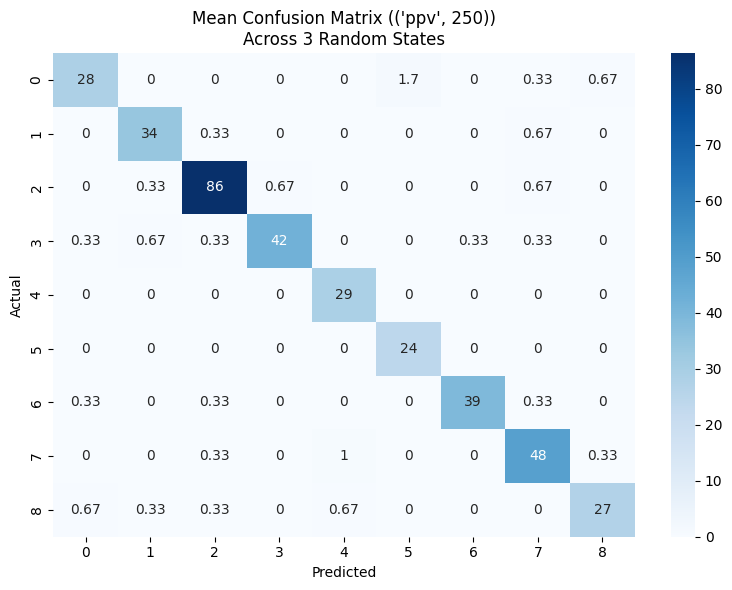

Average accuracy for ('ppv', 500): 0.974 ± 0.003


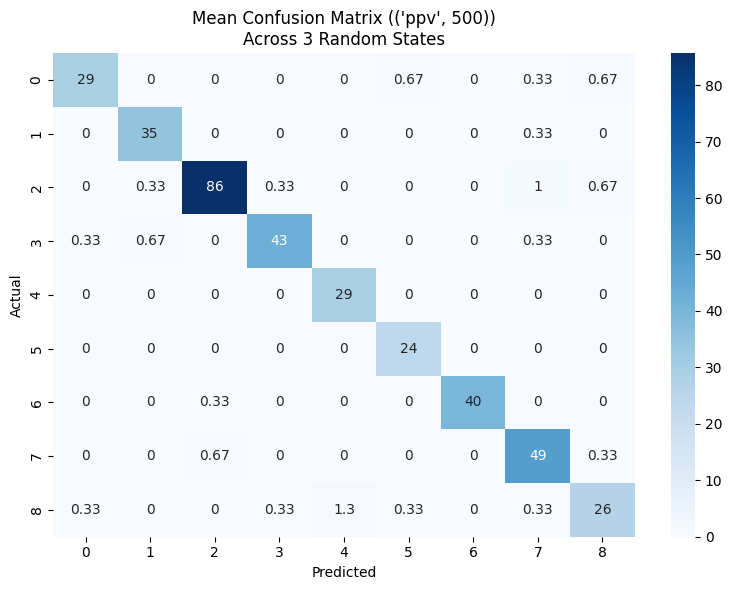

Average accuracy for ('ppv', 750): 0.976 ± 0.004


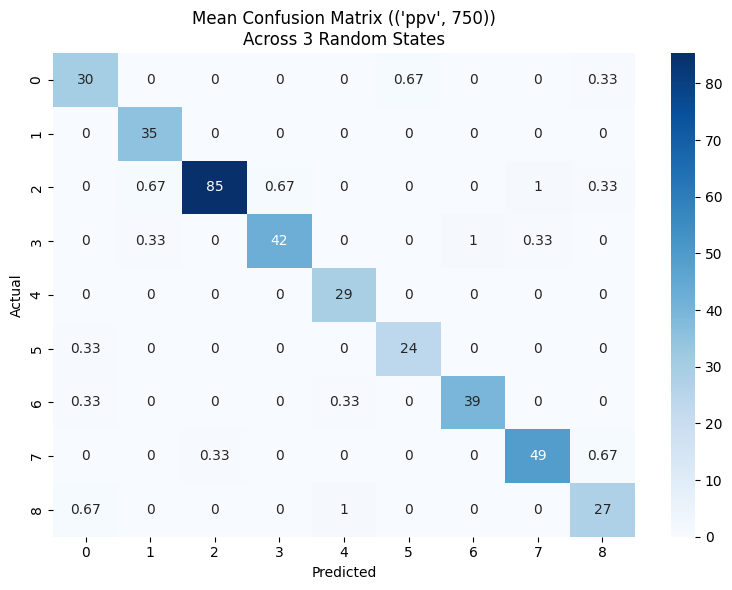

Average accuracy for ('ppv', 1000): 0.978 ± 0.002


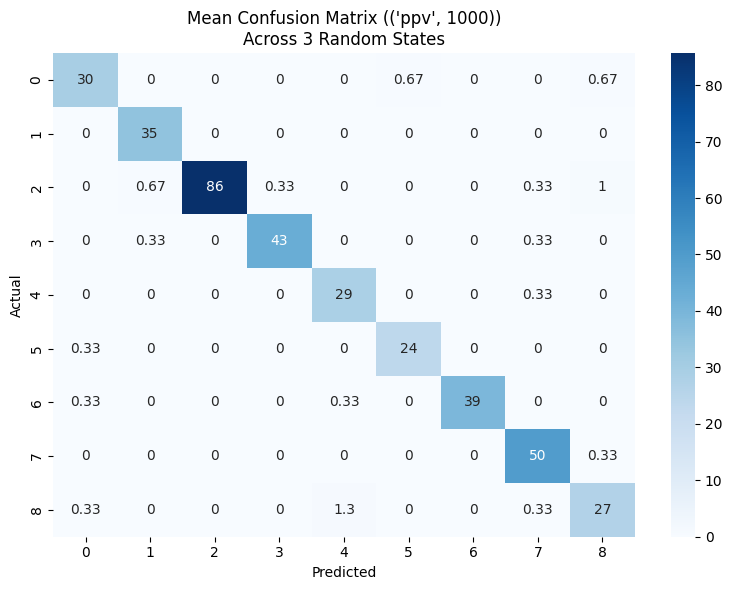

Average accuracy for ('max', 250): 0.983 ± 0.001


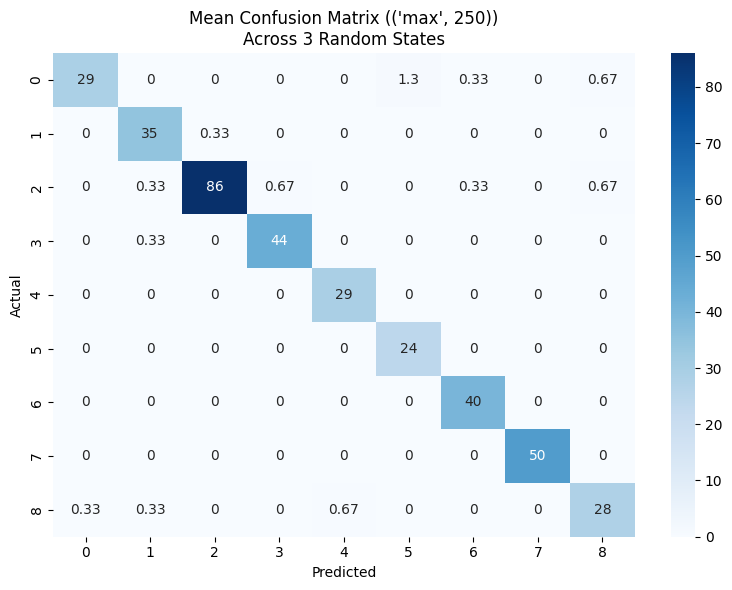

Average accuracy for ('max', 500): 0.986 ± 0.001


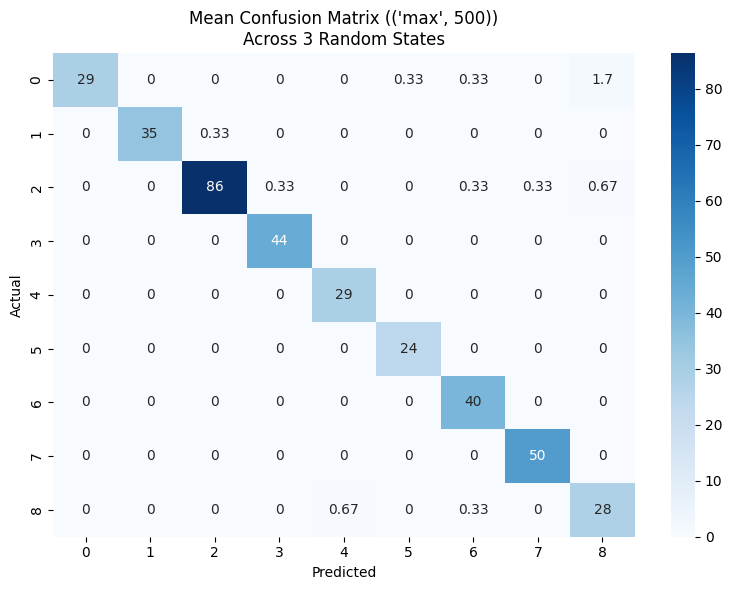

Average accuracy for ('max', 750): 0.985 ± 0.005


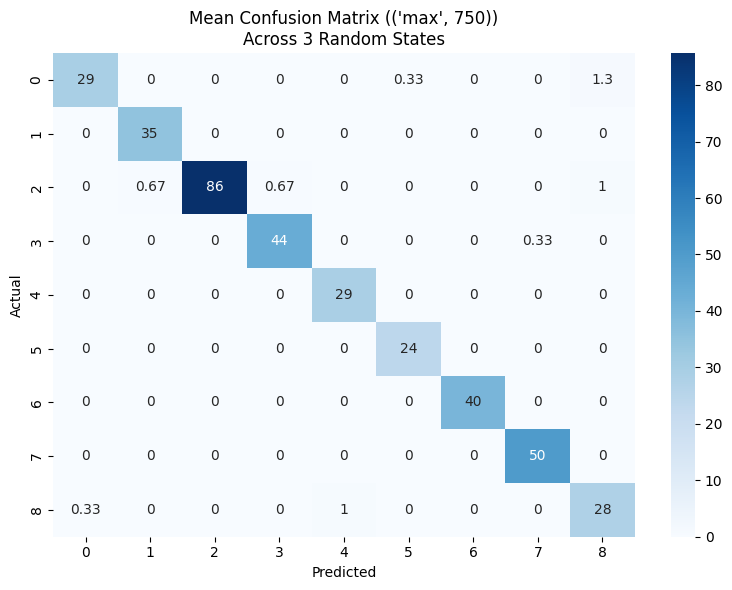

Average accuracy for ('max', 1000): 0.994 ± 0.003


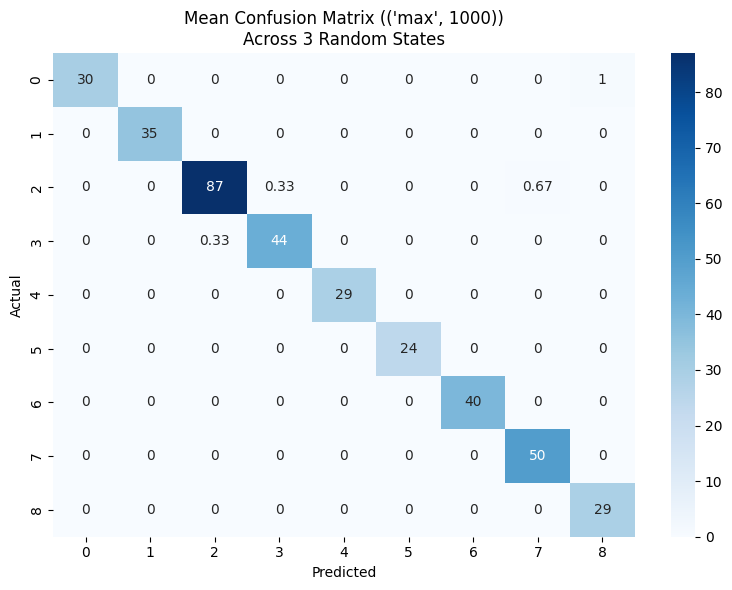

Average accuracy for ('ppv+mean', 250): 0.973 ± 0.006


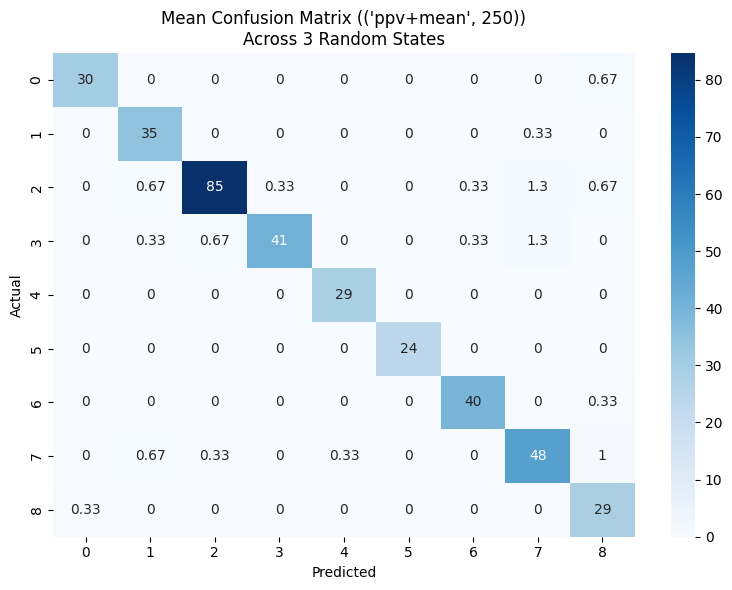

Average accuracy for ('ppv+mean', 500): 0.980 ± 0.003


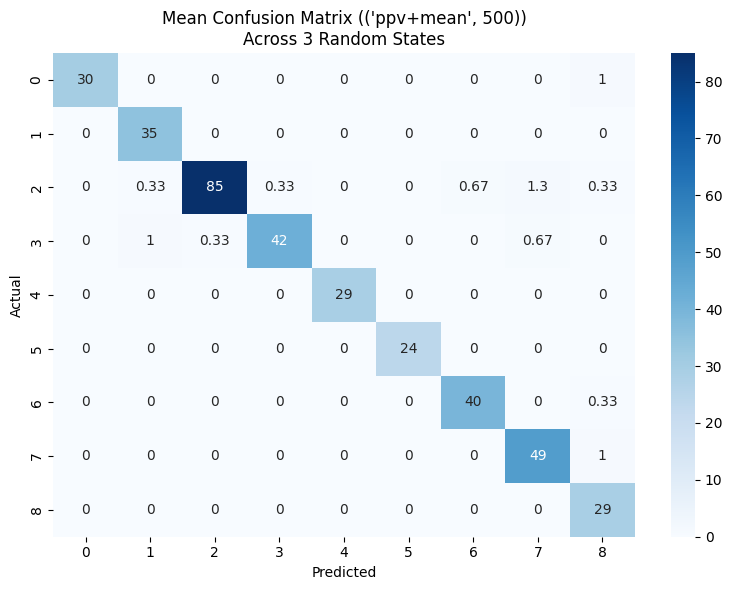

Average accuracy for ('ppv+mean', 750): 0.986 ± 0.001


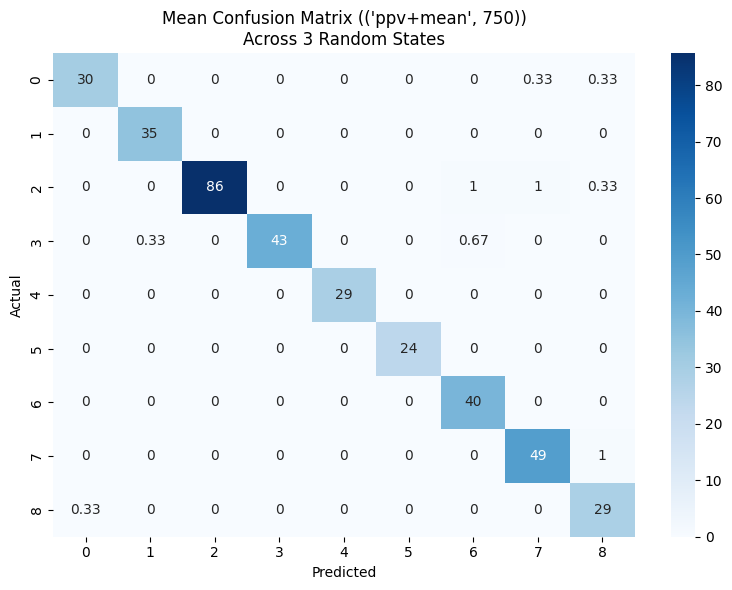

Average accuracy for ('ppv+mean', 1000): 0.982 ± 0.001


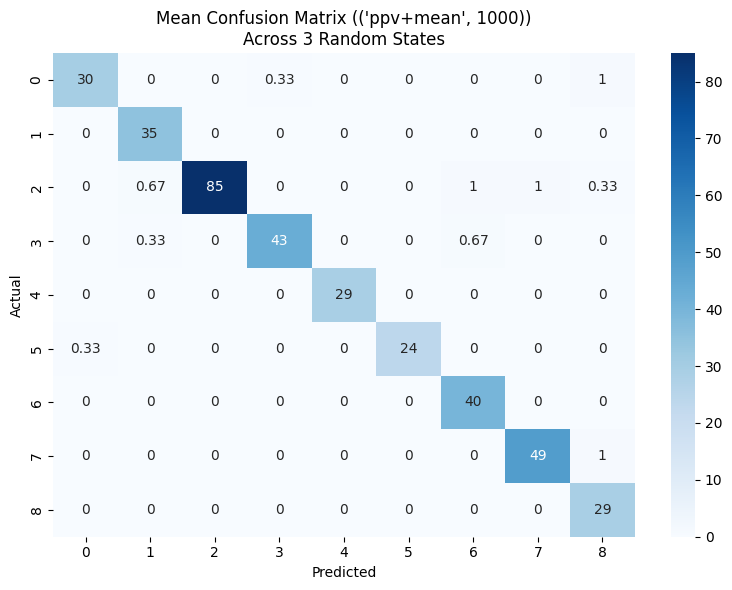

Average accuracy for ('ppv+max', 250): 0.983 ± 0.001


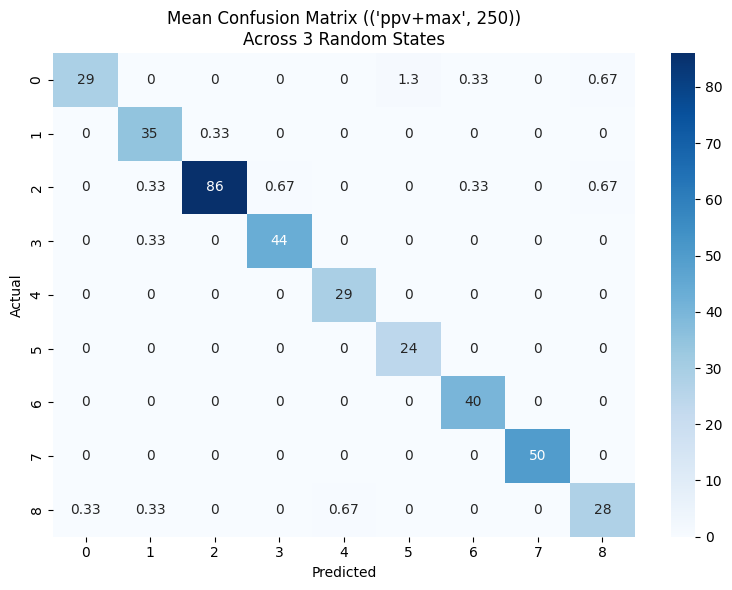

Average accuracy for ('ppv+max', 500): 0.986 ± 0.000


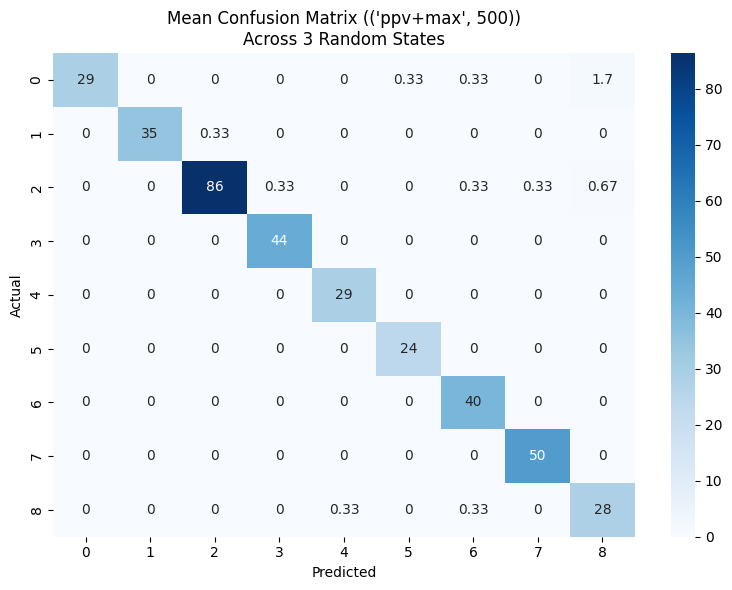

Average accuracy for ('ppv+max', 750): 0.984 ± 0.006


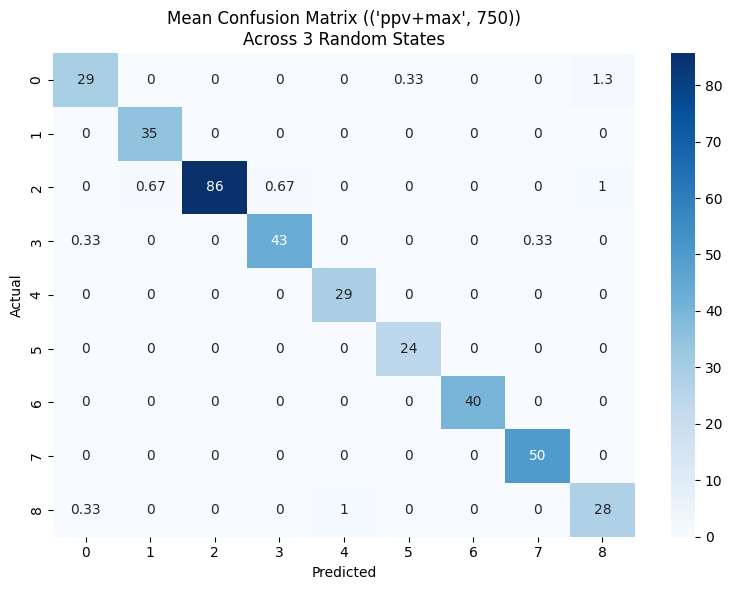

Average accuracy for ('ppv+max', 1000): 0.994 ± 0.003


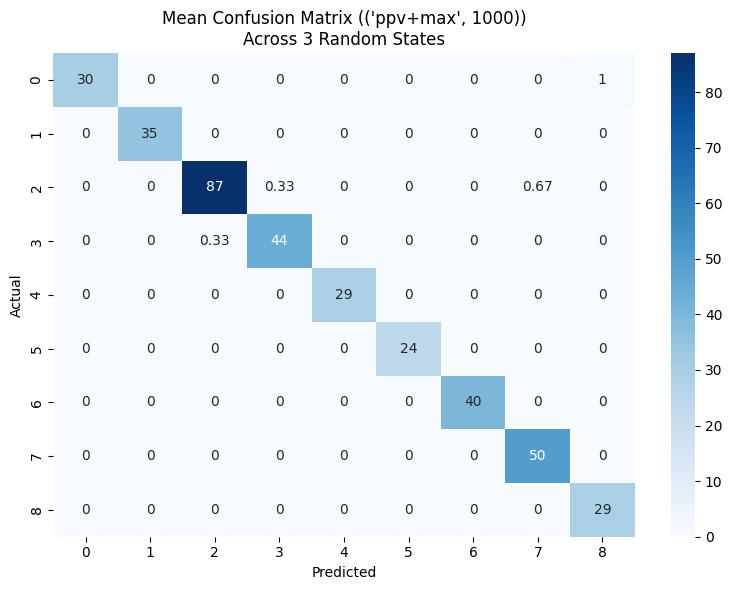

In [12]:
for key in results.keys():
    print(f"Average accuracy for {key}: {results[key]['mean_accuracy']:.3f} ± {results[key]['std_accuracy']:.3f}")
    cm = results[key]['mean_confusion_matrix']
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, cmap='Blues', cbar=True,
                xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
    plt.title(f'Mean Confusion Matrix ({key})\nAcross {len(random_states)} Random States')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()

    

Saving results

In [13]:
import pickle

with open('results_norm.pickle', 'wb') as handle:
    pickle.dump(results, handle)